# Basics of mobile robotics [MICRO-452]  
## Project report, EPFL Robotic Master, 12.12.21

<img src="image/logo-epfl.png" alt="Drawing" style="width: 200px;"/>

Author: **Nour Tnani [296442], Xavier Nal [288275], Alicia Mauroux [274618], Antoine Perrin [283652]**

Repository github : https://github.com/antoinetx/Mobile_robot.git

## 0. Introduction
Our project is to find a parking spot to our Thymio and to guide it to this spot using Global Navigation. We imagined it in a whole city like in this figure:
<img src="image/map_multi.jpg" alt="Drawing" style="width: 200px;"/>

But for this project, we focused only on a part of the map like you can see in the figure2. Thymio will evolve on this map where there is two houses and four parking spots. Three of this spots are occupied and only one of them is free. There will be some "dumb" Thymio that will evolve in this map too, our Thymio have to avoid them, using Local Navigation. 

Here is our map:

Figure2: Green = parking spots, Blue = obstacles, Black = "dumb" Thymio's path
<img src="image/map.jpg" alt="Drawing" style="width: 400px;"/>

For this project, we chose to cut the work in 4 parts:
- **Computer Vision and Kalman Filter** [Filtering + Vision]
- **Map initialisation and optimal path calculation** [Global Navigation]
- **Following the logical path** [Motion Control]
- **Local Navigation and Implementation of the "Dumb" Thymio** [Local Navigation]

We individually worked on those and then added slowly one part with another and when the result was good, we added another part and so on. 


## 1. Theoretical explanation
This part explain how we implement our idee of the project

### 1.1 Computer vision and Kalman filter

The camera allows us to implement the computer vision module. We use it to manage the Global Navigation. With the analysis of the video from the camera, we will extract the obstacles’ center position and their size, the parking slots, in addition to the position of the robot all along the road to its goal. The camera will give us the image with an RGB array where we will have all the pixels of the map. 
To implement the image processing, we essentially use the library  “ OpenCV”. This library includes very useful functions to extract data from a picture. As for the detection of the colors in the image, the work of the Youtube channel L42Project (the GitHub repository is https://github.com/L42Project/Tutoriels/tree/master/Divers/tutoriel36) was very helpful. We have also based our Kalman filter on this repository.


The main part of the vision was to detect the position of the robot at each iteration. This means the x and y robot positions as well as its orientation. In order to do this, we have put on the robot two purple/pink points to get a vector of the position. Therefore, the angle orientation is computed by finding the angle between the vector position and the x-axis. 
The detection of these points is based on the fact that the biggest purple/pink point on the map will be the bottom point of the robot, and the second biggest one is the top point of the robot. 
For this, we select all the purple/pink points larger than a certain area and we sort the points to find the two biggest. This is done with the help of the sort() methods from OpenCV.
The mask for the blue and green shape is made with the methods from OpenCV findContour().


The Kalman as mentioned above is based on the Kalman Filter from the L42Project. However, we made several changes to adapt the code to our project. 
We have modified the matrix by giving the measure of the speed in the Observation matrix and to improve the prediction. There were some difficulties to find the good size of the matrix and the right values. But the main challenge was to have a Kalman filter which provides us coherent values when the camera has some quick moments of absence. To solve this problem, we use two different Kalman filters (one for each point on the robot) to be able to compute the orientation in case the camera cannot give it to us. Indeed, we need for our system the position and the orientation of the robot to set the speed of the wheels. And by knowing the position of the two points on the robot, we can identify a vector position and hence the angle with the x axis.

### 1.2 Map initialisation and optimal path calculation

In this part we will see how we set and use the map to compute the optimal path that the robot has to follow to arrive on a free parking slot.

Type of path calculation : We choose to implement the A* algorithm that we have see during the course and the exercices.
In order to do that, we had to transform the frame that the camera give us to a grid of desired lenght.
We then speek of square by side and no more pixel by side. 
We choose the square by side to have a good precision but a low cost of calculation. Therefore we have to deal between thoses too parameters. After some testing we choose avalue of 50 squares for the smallest side. That give us  
Those are the steps that we applied on the frame to obtain a final squared wanted grid with the obstacles in it : 
- Take the frame
<img src="image/frame.jpg" alt="Drawing" style="width: 400px;"/>
- Extract the obstacle from a mask to see only the bleue(the obstacle) --> implemented by the vision part
<img src="image/masque1.jpg" alt="Drawing" style="width: 200px;"/>
<img src="image/masque2.jpg" alt="Drawing" style="width: 200px;"/>
- Expand the obstacle on the mask grid. To add a security and avoid the robot collapsing with the obstacle
<img src="image/secured.jpg" alt="Drawing" style="width: 100px;"/>
- Resize the expand mask grid to have a wanted squared dimention and no more pixels dimention. This is the final grid.
<img src="image/rezize.jpg" alt="Drawing" style="width: 100px;"/>
- Compute the optimal path from the A* algorithm.
<img src="image/TOTAL.jpg" alt="Drawing" style="width: 400px;"/>
We run this "initialisation" one time before the "runing" loop to avoid useless recomputation of the path each time.

Once the optimal path has been compute, we defined the current goal as the next path point until we are on the final goal. We then have implemented a fonction to update the current goal to send to the control and movement part (see 1.3). 
Now the robot just have to follow the updated current goals.


### 1.3 Robot control and path following 


The function takes continuously as parameters the position of the robot and its angle which are given by the Vision module. The angle is in the range of [-pi, pi]. It also takes as parameters the continuously updated goals that are given by the Optimal Path module.

We implement a function that computes the error in position (which is the distance between the goal and the robot) and the error in angle (We are inspired by the function described in https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python to determine the angle of the goal. We changed it to be optimal to the variation we want from the robot (all explained in the comments)).

As the angle is computed as a difference between the goal and the robot, if it's positif, then the robot should turn to the left, and if it's negatif, it should turn to the right, which is why we substract the angular error from the right motor speed, and add it to the left motor speed. 

In a more general way, the function "move_to_position" implements a PD (Proportionnal Derivative Controller), by adding a certain speed computed via the remaining distance (multiplied by an experimental coefficient) and adding/substracting an angular speed (multiplied by another experimental coefficient) to the motor's speed. These are added to some basic speed, because otherwise the speed of the robot will be almost zero when it reaches the updated goals. 

<img src="image/shema_nour.png" alt="Drawing" style="width: 400px;"/>

### 1.4 Local navigation and "Dumb" robot implementation
We use the local navigation in order to avoid the other cars of the "city". Those other cars are the "dumb" Thymio in this project. Our principle is the following:
<img src="image/MAIN_LN.jpg" alt="Drawing" style="width: 400px;"/>

We chose to make our Thymio go a little bit wider in order to let the "Dumb" Thymio leaves without any collision. 

**We disable this avoid functionality when we are soon arrived to the parking place** in order to make the parking maneuvers easier for Thymio. 

The implementation of the avoid function was inspired by the exercices of the course from the week 4. It means that we used the principle that when the robot "sees" an object in front of it, we accelerate the weels near this obstacle. We don't use the external horizontal sensors because we would like to be able to follow walls. However, we use them to compute the value of the speed when there's an object detected. It allow us to be more precise (regarding our tests). As we don't want to see the walls to early (otherwise we could not follow the optimal path without interupting it all the time) we avoid obstacles at a very short distance. To be able to do that, we turn on the same spot and not "smoothly" like in the exercices. 

Also, we saved in a global variable if the robot saw an object to the right or to the left. The main reason is to help Thymio to turn back if it is bloqued. The other reason is that it makes our turns more clean when there's an object in one side if we turn on the same spot even is the left obstacle is far.

We also computed differently our speed if there was an obstacle only in front of Thymio (otherwise it would turn very large and would often crash into the object). We kept the principle to compute the speed regarding the sensors values in order to give a smoother change of speed. 

In order to check if there's no more obstacles in Thymio's way, we are checking the front and the two interior side sensors but not the external side ones in case we would be along a wall. 

About the "dumb" robot implementation, it is developped in a different section below as we thought it was more logical that way. 

## 2. Step by step Code
To launch all the project, go in in section 3
### 2.1 Connection to Thymio and libraries
The next cells import all the libraries and the other folders that we will need

In [1]:
import tdmclient.notebook
await tdmclient.notebook.start()

import cv2
import math
import time

import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import size
from matplotlib import colors
from asgiref.sync import sync_to_async #in order to load variables to communicate between sync and async
import numpy.linalg as LA

import optimal_path as op
from robot import Robot
from Map import Map
from Local_navigation import* 
from Mouvement import*
from vision import*
from optimal_path import* 




### 2.2 Useful functions
Functions in order to use Thymio's actuators and sensors easily

In [2]:
def motors(l_speed=500, r_speed=500, verbose=False):
    """
    Sets the motor speeds of the Thymio 
    param l_speed: left motor speed
    param r_speed: right motor speed
    param verbose: whether to print status messages or not
    """
    global motor_left_target, motor_right_target
    # Printing the speeds if requested
    if verbose:
        print("\t\t Setting speed : ", l_speed, r_speed)
    motor_left_target = l_speed
    motor_right_target = r_speed

In [3]:
def proxi():
    """
    Returns the proximity values of the Thymio 
    """
    global prox_horizontal
    return prox_horizontal

### 2.3. Initialisation


In this part we initialise all the values, object, element that we are going to use

#### 2.3.1 Init the different object : 
- The Robot
- The Map
- The Kalman filter

We first initialise the parameter that will be usefull for the overall code


In [4]:
map_lenght = 1
nb_of_square_by_side = 40
current = 0

global move 
old_distance = 0
old_angle = 0
ERR_POS = 3
speed_right = 0
speed_left = 0
thresh_indentation = 15 #nb of idx before the final path node for with we set the proxi off


#Enable variables:
move = False #bool which indicate how our robot is moving (1: avoid an object VS 0: following the optimal path)
kalman_bool = False
enable_blue_pos = False
enable_green_pos = True
enable_path_display = True
soon_arrived = False


George = Robot()
Lausanne = Map(map_lenght, nb_of_square_by_side)
KF = KalmanFilter(0.1,[0.0,0.0])
KF2 = KalmanFilter(0.1,[0.0,0.0])

#### 2.3.2 Start the camera and take the original frame




In [5]:
VideoCap=cv2.VideoCapture(1)

# Take the frame nb "nb_frame_to_take":
nb_frame_to_take = 10

for i in range (nb_frame_to_take): 
    ret, frame = VideoCap.read()
    
print("frame size", frame.shape)

frame size (1080, 1920, 3)


#### 2.3.3 Map initialisation




In [6]:
print("MAP INITIALISATION")

# Set the pourcentage value between the nb of pixel and nb of square by side
Lausanne.set_map_lenght(frame)

# Set the robot goal, position and angle
goal = init_goal(frame, Lausanne.get_pourcentage())


print("   - first while")

pos_robot = (-1,-1)
#Use to be sure to have a correct start position to start the next computations
while (pos_robot[0] <= 0) & (pos_robot[1] <= 0):
    print("searching for the strart pos")
    
    ret, frame=VideoCap.read()
    pos_robot,pos_robot2, angle, bool_mesure = update(frame, Lausanne.get_pourcentage())  # fonction qui retourne la position angle etc....

#save values in the robot object
George.set_angle(angle)
George.set_goal(goal)
George.set_start_pos(pos_robot)
George.set_pos(pos_robot)
George.set_current(current)
print ("    --> goal", goal)
print ("    --> start position", pos_robot)



# SET MAP
print("   - Set the map parameters")
Lausanne.set_map_lenght(frame)
#print("Lausanna lenght", Lausanne.get_lenght())

# MASK 
print("   - Extract masks")
mask_bleu, mask_green = mask_map_init(frame)

#Uncomment to save the mask frame in jpg format:
#cv2.imwrite("masque1.jpg", mask_bleu)
#cv2.imwrite("masque2.jpg", mask_green)

# Fin de l'init
print("   - Grid initialisation")
Lausanne.init_grid(mask_bleu,mask_green)
grille = Lausanne.get_map()

#Uncomment to save the grid frame in jpg format:
#cv2.imwrite("grille.jpg", grille)


MAP INITIALISATION
   - first while
searching for the strart pos
    --> goal (49, 15)
    --> start position (11, 33)
   - Set the map parameters
   - Extract masks
   - Grid initialisation


#### 2.3.4 Path computation

Here we compute the optimal path and save the values in the robot object




In [7]:
# OPTIMAL PATH
print("PATH COMPUTATION")
path, visitedNodes = op.path_computation(George.get_start() , George.get_goal() , Lausanne.get_lenght(), grille)

George.set_path(path) 
George.set_visit_nodes(visitedNodes) 
print("PATH COMPUTED")

PATH COMPUTATION
PATH COMPUTED


#### 2.3.5 Initialisation's display

Here we desplay the initialised map and optimal path

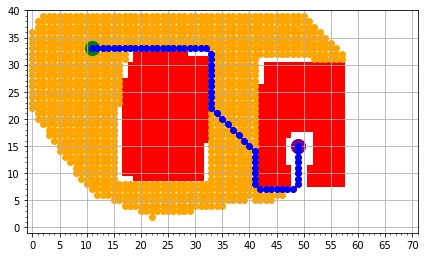

In [8]:
# Display the optimal path
op.display_map(Lausanne.get_lenght(),  grille,  George.get_visit_nodes(), George.get_path(), George.get_start(), George.get_goal())

# Display the path on the first frame.
display (frame, enable_blue_pos, enable_green_pos, enable_path_display, George.get_path(), Lausanne.get_pourcentage())

#Uncomment to save the final grid frame in jpg format:
#cv2.imwrite("TOTAL.jpg", frame)

### 2.4. Main loop

This is the main loop that update the position of the robot and make him move. This section work as follow:

- Update the position and angle from the camera
- Use Kalman filter to return predicted path
- Check if the robot is on the goal
- Check if there is an obstacle
        - If yes, avoid it
        - If no, follow the optimal path
- Display 
- Made the robot parking

In [9]:
print('START MOUVEMENT')
while True:
    # Read the camera
    ret, frame=VideoCap.read(1)
    
    # Get position and angle of the robot: 
    pos_robot, pos_robot2, angle_robot, bool_mesure = update(frame, Lausanne.get_pourcentage())
    
    # predict position and angle values of the robot
    pos = KF.kalmanFilter(bool_mesure, speed_left, speed_right, pos_robot, angle_robot)
    pos2 = KF2.kalmanFilter(bool_mesure, speed_left, speed_right, pos_robot2, angle_robot)
    x = pos2[0]-pos[0]
    y = pos2[1]-pos[1]
    angle_robot2 = KF.angle_of_vectors_2(x, y, 1, 0)
    
    #save the predicts values
    George.set_pos(pos)
    George.set_angle(angle_robot2)
    
    # Check if the robot is arrived
    if(current < George.get_path().shape[1]-1):
        current = path_update(pos, ERR_POS, np.transpose(George.get_path())[current], George.get_current())#
        George.set_current(current)
    else:
        print("READY TO PARK")
        motors(0,0)
        break
    
    # take the currrent goal
    pos_goal =  np.transpose(George.get_path())[current]
    
    #check if the robot is soon arrived
    if current > (George.get_path().shape[1] - thresh_indentation) :
        soon_arrived = True
        print('soon arrived')
    
    # Extract the proximity sensors
    proximity = proxi()
    
    
    #LOCAL NAVIGATION: check if there is an obstacle. If yes, avoid it.
    if move and not (soon_arrived):
        #Thymio is avoiding obstacles
        speed_l, speed_r, move = avoid_obstacle(prox_horizonta=proximity) 
    else:
        #Thymio is following the optimal path
        speed_l, speed_r, old_distance, old_goal  = move_to_position( pos, angle_robot2, pos_goal, old_distance, old_angle)#
        #Thymio is checking if there's an obstacle in front of it
        move = check_cars(prox_horizonta=proximity)
       
    # Save and set the speeds of the motors
    speed_right =  speed_r
    speed_left = speed_l
    motors(speed_l, speed_r) 
    
    # Display the map
    display (frame, enable_blue_pos, enable_green_pos, enable_path_display, path, Lausanne.get_pourcentage())
    
    # Quit when we press q
    keyVal = cv2.waitKey(1) & 0xFF
    if keyVal == ord('q'):
        motors(0,0)
        break
     
    sleep(0.1)

# The robot go forward 2 seconds to park:

print("Park")   
motors(70,70)
sleep(2)
motors(0,0)

print("ARRIVED")
    

START MOUVEMENT
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
next goal plz
soon arrived
next goal plz
soon arrived
soon arrived
soon arrived
soon arrived
soon arrived
soon arrived
soon arrived
soon arrived
soon arrived
soon arrived
soon arrived
next goal plz
soon arrived
soon arrived
soon arrived
soon arrived
next goal plz
soon arrived
soon arrived
soon arrived
next goal plz
soon arri

## 3. Launch all the code
This section allow to lauch all the code in 1 time

In [10]:
import tdmclient.notebook
await tdmclient.notebook.start()

print("Conected")

import cv2
import math
import time

import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import size
from matplotlib import colors
from asgiref.sync import sync_to_async #in order to load variables to communicate between sync and async
import numpy.linalg as LA

import optimal_path as op
from robot import Robot
from Map import Map
from Local_navigation import* 
from Mouvement import*
from vision import*
from optimal_path import* 

@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500, verbose=False):
    """
    Sets the motor speeds of the Thymio 
    param l_speed: left motor speed
    param r_speed: right motor speed
    param verbose: whether to print status messages or not
    """
    global motor_left_target, motor_right_target
    # Printing the speeds if requested
    if verbose:
        print("\t\t Setting speed : ", l_speed, r_speed)
    motor_left_target = l_speed
    motor_right_target = r_speed
    
@tdmclient.notebook.sync_var 
def proxi():
    """
    Returns the proximity values of the Thymio 
    """
    global prox_horizontal
    return prox_horizontal


map_lenght = 1
nb_of_square_by_side = 40
current = 0

global move 
old_distance = 0
old_angle = 0
ERR_POS = 3
speed_right = 0
speed_left = 0
thresh_indentation = 15 #nb of idx before the final path node for with we set the proxi off


#Enable variables:
move = False #bool which indicate how our robot is moving (1: avoid an object VS 0: following the optimal path)
kalman_bool = False
enable_blue_pos = False
enable_green_pos = True
enable_path_display = True
soon_arrived = False


George = Robot()
Lausanne = Map(map_lenght, nb_of_square_by_side)
KF = KalmanFilter(0.1,[0.0,0.0])
KF2 = KalmanFilter(0.1,[0.0,0.0])


VideoCap=cv2.VideoCapture(1)

# Take the frame nb "nb_frame_to_take":
nb_frame_to_take = 10

for i in range (nb_frame_to_take): 
    ret, frame = VideoCap.read()
    
print("frame size", frame.shape)


print("MAP INITIALISATION")

# Set the pourcentage value between the nb of pixel and nb of square by side
Lausanne.set_map_lenght(frame)

# Set the robot goal, position and angle
goal = init_goal(frame, Lausanne.get_pourcentage())


print("   - first while")

pos_robot = (-1,-1)
#Use to be sure to have a correct start position to start the next computations
while (pos_robot[0] <= 0) & (pos_robot[1] <= 0):
    print("searching for the strart pos")
    
    ret, frame=VideoCap.read()
    pos_robot,pos_robot2, angle, bool_mesure = update(frame, Lausanne.get_pourcentage())  # fonction qui retourne la position angle etc....

#save values in the robot object
George.set_angle(angle)
George.set_goal(goal)
George.set_start_pos(pos_robot)
George.set_pos(pos_robot)
George.set_current(current)
print ("    --> goal", goal)
print ("    --> start position", pos_robot)



# SET MAP
print("   - Set the map parameters")
Lausanne.set_map_lenght(frame)
#print("Lausanna lenght", Lausanne.get_lenght())

# MASK 
print("   - Extract masks")
mask_bleu, mask_green = mask_map_init(frame)

#Uncomment to save the mask frame in jpg format:
#cv2.imwrite("masque1.jpg", mask_bleu)
#cv2.imwrite("masque2.jpg", mask_green)

# Fin de l'init
print("   - Grid initialisation")
Lausanne.init_grid(mask_bleu,mask_green)
grille = Lausanne.get_map()

#Uncomment to save the grid frame in jpg format:
#cv2.imwrite("grille.jpg", grille)


# OPTIMAL PATH
print("PATH COMPUTATION")
path, visitedNodes = op.path_computation(George.get_start() , George.get_goal() , Lausanne.get_lenght(), grille)

George.set_path(path) 
George.set_visit_nodes(visitedNodes) 
print("HOOOO")
# Display the optimal path
op.display_map(Lausanne.get_lenght(),  grille,  George.get_visit_nodes(), George.get_path(), George.get_start(), George.get_goal())
print("HIIIIII")
# Display the path on the first frame.
display (frame, enable_blue_pos, enable_green_pos, enable_path_display, George.get_path(), Lausanne.get_pourcentage())

#Uncomment to save the final grid frame in jpg format:
#cv2.imwrite("TOTAL.jpg", frame)


print('START MOUVEMENT')
while True:
    # Read the camera
    ret, frame=VideoCap.read(1)
    
    # Get position and angle of the robot: 
    pos_robot, pos_robot2, angle_robot, bool_mesure = update(frame, Lausanne.get_pourcentage())
    
    # predict position and angle values of the robot
    pos = KF.kalmanFilter(bool_mesure, speed_left, speed_right, pos_robot, angle_robot)
    pos2 = KF2.kalmanFilter(bool_mesure, speed_left, speed_right, pos_robot2, angle_robot)
    x = pos2[0]-pos[0]
    y = pos2[1]-pos[1]
    angle_robot2 = KF.angle_of_vectors_2(x, y, 1, 0)
    
    #save the predicts values
    George.set_pos(pos)
    George.set_angle(angle_robot2)
    
    # Check if the robot is arrived
    if(current < George.get_path().shape[1]-1):
        current = path_update(pos, ERR_POS, np.transpose(George.get_path())[current], George.get_current())#
        George.set_current(current)
    else:
        print("READY TO PARK")
        motors(0,0)
        break
    
    # take the currrent goal
    pos_goal =  np.transpose(George.get_path())[current]
    
    #check if the robot is soon arrived
    if current > (George.get_path().shape[1] - thresh_indentation) :
        soon_arrived = True
        print('soon arrived')
    
    # Extract the proximity sensors
    proximity = proxi()
    
    
    #LOCAL NAVIGATION: check if there is an obstacle. If yes, avoid it.
    if move and not (soon_arrived):
        #Thymio is avoiding obstacles
        speed_l, speed_r, move = avoid_obstacle(prox_horizonta=proximity) 
    else:
        #Thymio is following the optimal path
        speed_l, speed_r, old_distance, old_goal  = move_to_position( pos, angle_robot2, pos_goal, old_distance, old_angle)#
        #Thymio is checking if there's an obstacle in front of it
        move = check_cars(prox_horizonta=proximity)
       
    # Save and set the speeds of the motors
    speed_right =  speed_r
    speed_left = speed_l
    motors(speed_l, speed_r) 
    
    # Display the map
    display (frame, enable_blue_pos, enable_green_pos, enable_path_display, path, Lausanne.get_pourcentage())
    
    # Quit when we press q
    keyVal = cv2.waitKey(1) & 0xFF
    if keyVal == ord('q'):
        motors(0,0)
        break
     
    sleep(0.1)

# The robot go forward 2 seconds to park:

print("Park")   
motors(70,70)
sleep(2)
motors(0,0)

print("ARRIVED")



Exception: Node lock error

## 4. "Dumb" Thymio
We have implemented this code in another Thymio. The "Dumb" Thymio is the robot which will challenge the local avoidance of our main Thymio.

In this part, the "dumb" Thymio will follow a line until it sees an object in front of it. In this case, it stops (and screams) until the object is removed. We start the robot by pushing on its center button and we stop it the same way. 

We drew heavily on the code of the exercice of the course from the week 3. The main difference is that we check if we lost the lign to the left or to the right. It allows us to use our "Dumb" Thymio in the 2 directions. We saved what was our last turn is the variable "last turn" in order to be more efficient to find again the line in case Thymio would lost it because it was going too fast. 

We have chosen to flash this code into the robot as there was ne need to have communications with the computer for this part. 


To connect to the "dumb" Thymio:

In [4]:
import tdmclient.notebook
await tdmclient.notebook.start()

The code: 

In [12]:
%%run_python

# Implementation of **Dumb Thymio**
# 
# Author: Alicia Mauroux, Robotic MA1, Fall 2021

#constants and variables
white = 900
GOAL = 100
PROX = 2000
PROX_SIDE = 1600
SOUND = 5

lost = False
last_turn = False #False = left; True = Right
w_le = 0
w_ri = 0
state = 0

timer_period[0] = 100   # 100ms sampling time

######################
#     FUNCTIONS
#####################
@onevent
def button_center():
    """
    start/stop the robot by pushing on the center button 
    
    global state is the state of our Thymio (1 -> Thymio is running, 0 -> Thymio is sleeping)
    """
    global state
    if button_center == 1:
        state = 1 if state==0 else 0

def ground_white(white_threshold):
    """
    Tests whether the two (or one of the two) ground sensors have seen white
    
    param white_threshold: threshold starting which it is considered that the sensor saw white
    global turn_left means that Thymio is turning left
    global lost means that Thymio lost its lign
    global w_le is the left prox_ground value
    global w_ri is the right prox_ground value
    global last_turn indicate which was the last turn of Thymio 
    """
    global turn_left, prox_ground_reflected, lost, w_le, w_ri, last_turn
    
    w_le = prox_ground_reflected[0] 
    w_ri = prox_ground_reflected[1] 
    
    #white on the left --> turn right then to keep the track
    if (w_le > white_threshold):
        if (w_ri < white_threshold):
            turn_left = False
            lost = False
            last_turn = True #Last turn was to the right
            return True
    #white on both direction --> you lost the track! turn back
        else:
            lost = True
            turn_left = False
            return True    
    else:
    #white on the right --> turn left then to keep the track
        if(w_ri > white_threshold):
            lost = False
            turn_left = True
            last_turn = False #Last turn was to the left
            return True
    #following the lign!
        else:
            lost = False
            turn_left = False
            return False

def test_object(prox_threshold,prox_threshold_side):
    """
    Tests whether the front proximity sensors saw an object on Thymio's way. If there's something, a sound will be played.
    
    param prox_threshold: threshold starting which it is considered that the sensor saw an object
    param prox_threshold_side: threshold starting which it is considered that the side sensor saw an object
    """
    global prox_horizontal
    
    if (prox_horizontal[2]>prox_threshold):
        nf_sound_play(SOUND)
        return True
    elif (prox_horizontal[1]>prox_threshold_side):
        nf_sound_play(SOUND)
        return True
    elif (prox_horizontal[3]>prox_threshold_side):
        nf_sound_play(SOUND)
        return True
    else:
        return False
        
def follow_lign(goal):
    """
    Will follow the lign by turning left/right each time the right/left ground sensor is seeing white
    
    param goal: It's the sensor's value of the black lign that Thymio is following 
    param prox_threshold_side: threshold starting which it is considered that the side sensor saw an object
    global lost: means that Thymio lost its lign
    global w_le: is the left prox_ground value
    global w_ri: is the right prox_ground value
    global last_turn: indicate which was the last turn of Thymio 
    """
    global turn_left, lost, last_turn, motor_left_target, motor_right_target
    
    SPEED0 = 100
    SPEED_LOST = SPEED0//2
    TURN = 150

    if(test_object(PROX,PROX_SIDE)):
        l_speed = 0
        r_speed = 0
    else:
        l_speed = SPEED0
        r_speed = SPEED0

        if (ground_white(white)):
            if(turn_left):
                l_speed = l_speed - TURN
                r_speed = r_speed + TURN
            elif(lost):
                if(last_turn):
                    l_speed = SPEED_LOST
                    r_speed = -SPEED_LOST
                else:
                    l_speed = -SPEED_LOST
                    r_speed = SPEED_LOST
            else:
                l_speed = l_speed  + TURN
                r_speed = r_speed - TURN

    motor_left_target = l_speed
    motor_right_target = r_speed

##############################
#  MAIN LOOP OF DUMB THYMIO
##############################
@onevent 
def timer0():
    
    global motor_left_target, motor_right_target
    
    if state:
        follow_lign(GOAL)
    else:
        motor_left_target = 0
        motor_right_target = 0

## 5. few difficulties

We had few situation that cause us some trouble.

We often had to adapt the extracted color since the light in the room was never the same during different time of the day/night.
We had to find a solution for the robot to see the wall when he was avoiding a "dumb" robot but not when he was parking.
We havn't manage to turn off all the leds of the robot. We have been then obliged to put some paper on the robot to hide the leds.

## 6. Conclusion

In conclusion, it was a very nice project and it went well. We were a good team and it was easy to work with each other. With this project, we had a good overview of what we can do in python with a robot like Thymio. 
To have taken the course of "Systèmes embarqués et robotique [MICRO-315]" was very helpful for this project as it was more familiar to us where to search and find the informations we need. The most difficult part was the computer vision as it was new to us. 

We realized that we asked something difficult to our robot with the sensors we have on the Thymio about the avoiding of obstacles. We made this part a little bit easier than expected. 

This project show us that the grid approch for path calculation or robot dynamic positioning is not adequate for big map since the cost of calculation is lot's higher than an edge obstacle detection.
To improve this project we can improve the way we do the calculation on the grid expension or path calculation with Dijkstra algorithm for exemple.

## 10. Sources
- https://pypi.org/project/tdmclient/ 
- http://wiki.thymio.org/en:thymioapi
- https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
- Exercices from the course (Basics of mobile robotics [MICRO-452])
- Control your Thymio in Python
- https://github.com/L42Project/Tutoriels/tree/master/Divers/tutoriel36



